In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


In [3]:
# NYTimes US county level COVID-19 data 
url = "https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2Fnytimes%2Fcovid-19-data%2Fmaster%2Fus-counties.csv&filename=us-counties.csv"


In [4]:
### check if we need to download a new file for today, based on the date
### filename is covid19data_YYYYMMDD.csv

### download new file

### set 

In [5]:
df = pd.read_csv(url, usecols=lambda x: x.lower() not in ('fips'))

df

df.index

df[df['state'] == 'Texas']

In [6]:
tx = df[df['state'] == 'Texas']
txdfw = tx[tx['county'] == 'Dallas']

#df_tx_pivot = tx.pivot(index='date', columns='county', values='cases')
df_txdfw_pivot = txdfw.pivot(index='date', columns='county', values=['cases', 'deaths'])

df_txdfw_pivot

#df_tx_pivot.plot(figsize=[15, 10])
df_txdfw_pivot.plot(figsize=[15, 10])

#fig, axes = plt.subplots()


fig = plt.figure(figsize=[15, 10])
matplotlib.rcParams.update({'font.size': 12, 'font.family': 'sans'})

axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes.plot(df_txdfw_pivot['cases'])
axes.set_ylabel('# Cases')
#axes.secondary_yaxis

#ax = df_txdfw_pivot.plot(figsize=[15, 10], secondary_y=['deaths'])
#type(ax)
#df_txdfw_pivot['deaths'].plot(secondary_y=True, figsize=[15, 10])

#ax.set_ylabel('# Cases')
#ax.right_ax.set_ylabel('# Deaths')


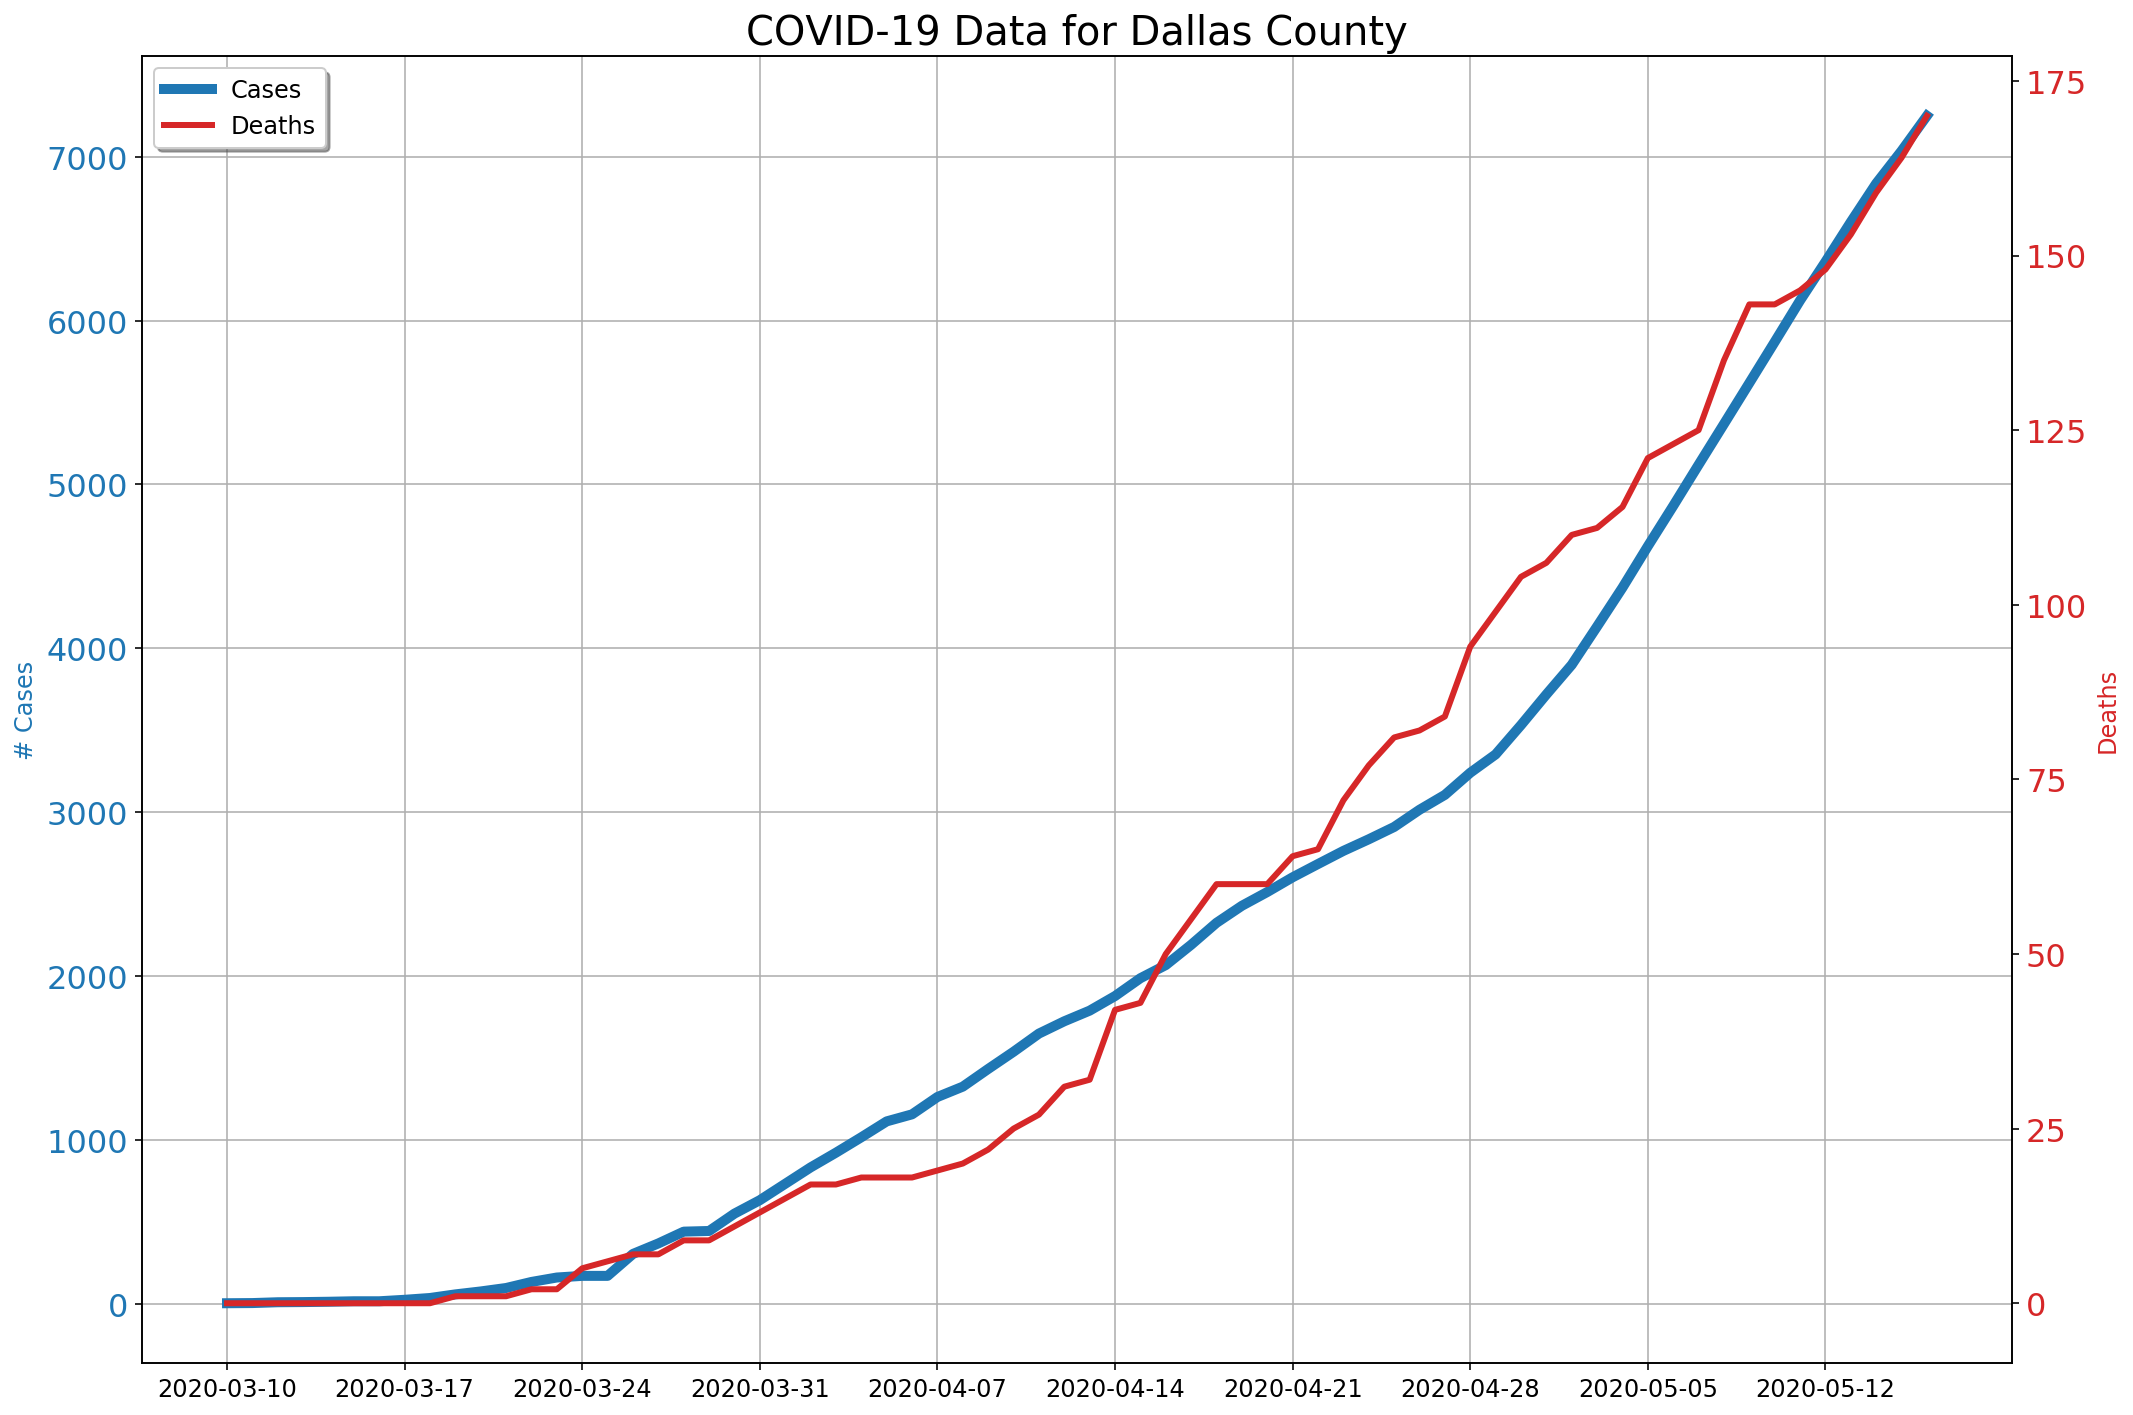

In [10]:
fig, ax1 = plt.subplots(figsize=[15,10])

matplotlib.rcParams.update({'font.size': 12, 'font.family': 'sans'})

## primary y axis - # Cases
color1 = 'tab:blue'
ax1.set_ylabel('# Cases', color=color1)
l1, = ax1.plot(df_txdfw_pivot['cases'], linewidth=5, color=color1)
ax1.set_xticks(ax1.get_xticks()[::7])
ax1.tick_params(axis='y', labelcolor=color1, labelsize=16)
ax1.grid(True)

## secondary y axis - # Deaths
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('# Deaths', color=color2)
l2, = ax2.plot(df_txdfw_pivot['deaths'], color=color2, linewidth=3)
ax2.set_xticks(ax2.get_xticks()[::7])
ax2.tick_params(axis='y', labelcolor=color2, labelsize=16)

ax1.legend((l1, l2), ('Cases', 'Deaths'), loc='upper left', shadow=True)
ax1.set_title("COVID-19 Data for Dallas County", fontsize=20)

fig.tight_layout()
plt.show()